In [2]:
# imports
import math
import cv2
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

## Load img & Color correction

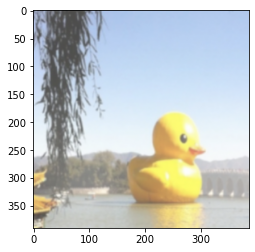

In [6]:
pic_name = '9.png'
im = np.array(cv2.cvtColor(cv2.imread(pic_name), cv2.COLOR_BGR2RGB).astype('double') / 255.0)
plt.imshow(im)
plt.show()

mu: 2.3
0.0 255.0
0.0 253.0
0.0 216.43768384402037


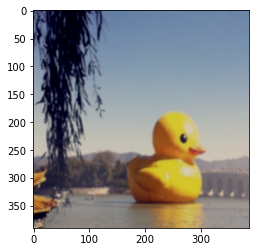

In [7]:
mu = 2.3
H,W,garbage = np.shape(im)

im_c = im*255
# for i in range(3):
#     var = np.sum((im_c[:,:,i]-np.mean(im_c[:,:,i]))**2)/(H*W)
#     var = np.sqrt(var)
#     print((np.max(im_c[:,:,i])-np.mean(im_c[:,:,i]))/var)
#     print((np.mean(im_c[:,:,i])-np.min(im_c[:,:,i]))/var)
#     mu = max(mu,(np.max(im_c[:,:,i])-np.mean(im_c[:,:,i]))/var)
#     mu = max(mu,(np.mean(im_c[:,:,i])-np.min(im_c[:,:,i]))/var)
#     # mx = np.mean(im_c[:,:,i])+mu*var
#     # mn = np.mean(im_c[:,:,i])-mu*var
#     # im_c[:,:,i] = (im_c[:,:,i]-mn)/(mx-mn)#*255
#     # print(np.min(im_c),np.max(im_c))
print('mu:',mu)
for i in range(3):
    var = np.sum((im_c[:,:,i]-np.mean(im_c[:,:,i]))**2)/(H*W)
    var = np.sqrt(var)
    mx = np.mean(im_c[:,:,i])+mu*var
    mn = np.mean(im_c[:,:,i])-mu*var
    x = (im_c[:,:,i]-mn)/(mx-mn)*255
    # x[x>1] = 1
    # x[x<0] = 0
    x[x>255] = 255
    x[x<0] = 0
    im_c[:,:,i] = x*1
    print(np.min(im_c),np.max(im_c))
im_c = im_c.astype(int)
plt.imshow(im_c)
plt.show()

81.51245


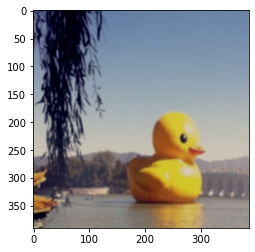

In [8]:
# print(np.max(im_c),np.min(im_c))
# print(im_c.dtype)
im_c = np.float32(im_c/255)
im_c_lab = cv2.cvtColor(im_c,cv2.COLOR_RGB2LAB)
print(np.max(im_c_lab[:,:,0]))
plt.imshow(cv2.cvtColor(im_c_lab,cv2.COLOR_LAB2RGB))
plt.show()


In [11]:
sigma = 7;
window_size = 3*sigma    
gaussian_kernel_1d = signal.gaussian(window_size, std=sigma).reshape(window_size, 1)
gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d)
gaussian_kernel_2d /= np.sum(gaussian_kernel_2d)

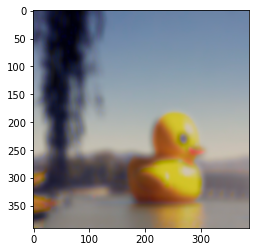

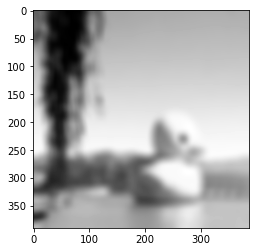

In [12]:
L = im_c_lab*1
L[:,:,0] = L[:,:,0]/100*255
I0 = np.abs(cv2.filter2D(L[:,:,0], -1, gaussian_kernel_2d))
L_ = L*1
L_[:,:,0]  = I0/255*100
L_ = cv2.cvtColor(L_,cv2.COLOR_LAB2RGB)
plt.imshow(L_)
plt.show()
plt.imshow(I0,cmap='gray')
plt.show()

## Tune Parameter

In [13]:
# Parameters
lamb = 10
alpha = 100
beta = 0.1
gamma = 1

In [14]:
R = np.zeros(np.shape(L[:,:,0]))
I = I0*1

0.80969095


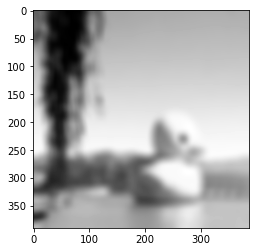

(0.9999999999999991-1.1102230246251565e-16j)


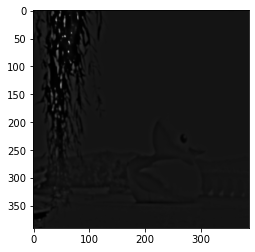

In [15]:
# calculate shrink part
diff_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
diff_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

dx = cv2.filter2D(R,-1,diff_x)
dy = cv2.filter2D(R,-1,diff_y)

max_dx = np.abs(dx)-0.5/lamb
dx = (max_dx>0).astype(float)*max_dx*((dx>=0).astype(float)-(dx<0).astype(float))

max_dy = np.abs(dy)-0.5/lamb
dy = (max_dy>0).astype(float)*max_dy*((dy>=0).astype(float)-(dy<0).astype(float))


# calculate R
# one = np.ones(np.shape(L[:,:,0]))
one = np.zeros(np.shape(L[:,:,0]))
# one[int(np.shape(one)[0]/2),int(np.shape(one)[1]/2)] = 1
one[0,0] = 1

print(np.min(I))
if np.min(I)==0:
    I+=1e-10
plt.imshow(I,cmap='gray')
plt.show()
R_1 = (1+beta*lamb)*np.fft.fft2(L[:,:,0]/I)
R_2 = np.fft.fft2(one) + beta*lamb*(np.fft.fft2(dx)*np.conjugate(np.fft.fft2(dx)) + np.fft.fft2(dy)*np.conjugate(np.fft.fft2(dy)))
print(np.min(R_2))
R_ = R_1/R_2
R = np.abs(np.fft.ifft2(R_))
# R = (R-np.min(R))/(np.max(R)-np.min(R))

# step = 5
# R = (R>np.mean(R)+np.std(R)*step)*(np.mean(R)+np.std(R)*step) + (R<np.mean(R)-np.std(R)*step)*(np.mean(R)-np.std(R)*step) + R*(R>=np.mean(R)-np.std(R)*step)*(R<=np.mean(R)+np.std(R)*step)
plt.imshow(np.abs(R),cmap='gray')
plt.show()

0.010614092461765395
[[ 58.57714467  62.08465576  88.69903564 ... 138.81500244 139.1418457
  139.1418457 ]
 [ 58.53073289  58.54395024  73.02612305 ... 138.81500244 139.1418457
  139.1418457 ]
 [ 58.44327169  58.45769127  58.70760744 ... 140.26245117 139.1418457
  139.25079346]
 ...
 [154.93927002 160.76019287 167.17254639 ... 160.93139648 159.29718018
  158.33221436]
 [175.07904053 179.23461914 181.21124268 ... 159.29718018 158.83026123
  158.61236572]
 [187.06329346 188.60412598 189.69360352 ... 157.6473999  157.86529541
  157.6473999 ]] 207.85675048828125 0.6553225310157779


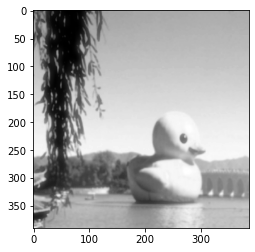

In [16]:
# calulate I
one = one*(1+gamma)
print(np.min(R))
if np.min(R)==0:
    R+=1e-20
I_1 = np.fft.fft2(gamma*I0+L[:,:,0]/R)
I_2 = np.fft.fft2(one)+alpha*(np.fft.fft2(dx)*np.conjugate(np.fft.fft2(dx))+np.fft.fft2(dy)*np.conjugate(np.fft.fft2(dy)))
I_ = I_1/I_2
I = np.real(np.fft.ifft2(I_))
I = (I>=L[:,:,0]).astype(float)*I+(I<L[:,:,0]).astype(float)*L[:,:,0]
# I = (I-np.min(I))/(np.max(I)-np.min(I))*230
print(I,np.max(I),np.min(I))
plt.imshow(I,cmap='gray')
plt.show()

627.5252 24.924556732177734 207.85675048828125


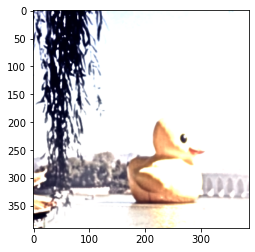

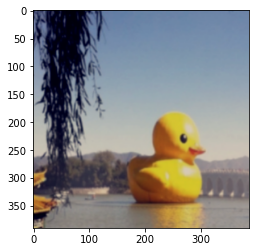

In [17]:
L_ = L*1
L_[:,:,0] = R*I/255*100
# L_[:,:,0] = R*I/255*100
print(np.max(L_[:,:,0]),np.max(R),np.max(I))
L_ = cv2.cvtColor(L_,cv2.COLOR_LAB2RGB)
plt.imshow(L_)
plt.show()
plt.imshow(im_c)
plt.show()

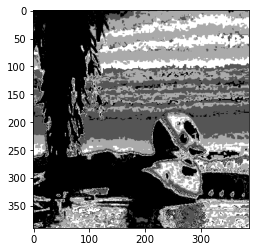

In [18]:
# remap I
decimal = 1
C = np.zeros(230*decimal+1)
for i in range(230*decimal+1):
    if i==0:
        C[i] = np.arctan(0-15)
    else:
        C[i] = C[i-1]+np.arctan(i/decimal-15)
C = C/C[230*decimal]

I_new = np.round(I*decimal)
upper_bound = np.int(np.max(np.round(I*decimal))+1)
sum = 0
for i in range(upper_bound):
    sum += np.arctan(i/decimal)*np.sum((np.round(I*decimal)==i))
# print(sum)
for i in range(upper_bound):
    c = np.arctan(i/decimal)*np.sum((np.round(I*decimal)==i))/sum
    idx = np.argmax(C>=c)
    I_new[np.round(I*decimal)==i] = idx
I_new = I_new/decimal
# print('I_new\n',I_new,'\n round(I) \n',np.round(I),'\n I \n',I,'\n I0 \n',I0)
plt.imshow(I_new,cmap='gray')
plt.show()

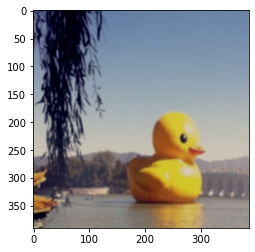

max: 207.85675048828125 34.0
min: 0.6553225310157779 31.0
mean: 136.48586596952893 32.16350471635446
std: 51.203581208165886 1.03063057476339
313.7626 24.924556732177734 207.85675048828125 0.0004258487954597221


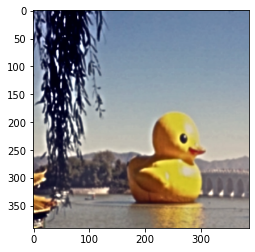

In [19]:
L_ = L*1
L_[:,:,0] = L_[:,:,0]/255*100
L_ = cv2.cvtColor(L_,cv2.COLOR_LAB2RGB)
plt.imshow(L_)
plt.show()

print('max:',np.max(I),np.max(I_new))
print('min:',np.min(I),np.min(I_new))
print('mean:',np.mean(I),np.mean(I_new))
print('std:',np.std(I),np.std(I_new))
# I = (I_new-np.mean(I_new))/np.std(I_new)*np.std(I)+np.mean(I)
# R = R/np.max(R)

L_ = L*1
L_[:,:,0] = R*I/255*100/2
print(np.max(L_[:,:,0]),np.max(R),np.max(I),np.min(R)/np.max(R))
L_ = cv2.cvtColor(L_,cv2.COLOR_LAB2RGB)
plt.imshow(L_)
plt.show()

In [22]:
# imports
import math
import cv2
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [148]:
#
# Input: im - image with RGB channels (the sequence is RGB) in range [0,1]
# Output: im_ - image with RGB channels (the sequence is RGB) in range [0,1]
def RETINEX_BASED(im):
    mu = 2.3
    H,W,garbage = np.shape(im)

    ################################################### Color Correction ########################################################
    im_c = im*255
    for i in range(3):
        var = np.sum((im_c[:,:,i]-np.mean(im_c[:,:,i]))**2)/(H*W)
        var = np.sqrt(var)
        mx = np.mean(im_c[:,:,i])+mu*var
        mn = np.mean(im_c[:,:,i])-mu*var
        x = (im_c[:,:,i]-mn)/(mx-mn)*255
        # x[x>1] = 1
        # x[x<0] = 0
        x[x>255] = 255
        x[x<0] = 0
        im_c[:,:,i] = x*1
        print(np.min(im_c),np.max(im_c))
    im_c = im_c.astype(int)
    im_c = np.float32(im_c/255)
    im_c_lab = cv2.cvtColor(im_c,cv2.COLOR_RGB2LAB)


    ################################################### Calculate I0 ########################################################
    sigma = 5;
    window_size = 3*sigma    
    gaussian_kernel_1d = signal.gaussian(window_size, std=sigma).reshape(window_size, 1)
    gaussian_kernel_2d = np.outer(gaussian_kernel_1d, gaussian_kernel_1d)
    gaussian_kernel_2d /= np.sum(gaussian_kernel_2d)
    L = im_c_lab*1
    L[:,:,0] = L[:,:,0]/100*255
    I0 = np.abs(cv2.filter2D(L[:,:,0], -1, gaussian_kernel_2d))

    ################################################### Parameters ########################################################
    lamb = 10
    alpha = 100
    beta = 0.1
    gamma = 1

    ###################################################### Loop ###########################################################

    #-------------- Initialize ----------------#
    R = np.zeros(np.shape(L[:,:,0]))
    I = I0*1

    #---------------- Shrink ------------------#
    diff_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    diff_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

    dx = cv2.filter2D(R,-1,diff_x)
    dy = cv2.filter2D(R,-1,diff_y)

    max_dx = np.abs(dx)-0.5/lamb
    dx = (max_dx>0).astype(float)*max_dx*((dx>=0).astype(float)-(dx<0).astype(float))

    max_dy = np.abs(dy)-0.5/lamb
    dy = (max_dy>0).astype(float)*max_dy*((dy>=0).astype(float)-(dy<0).astype(float))

    #---------------- R ------------------#
    one = np.zeros(np.shape(L[:,:,0]))
    # one[int(np.shape(one)[0]/2),int(np.shape(one)[1]/2)] = 1
    one[0,0] = 1

    if np.min(I)==0:
        I+=1e-10
    R_1 = (1+beta*lamb)*np.fft.fft2(L[:,:,0]/I)
    R_2 = np.fft.fft2(one) + beta*lamb*(np.fft.fft2(dx)*np.conjugate(np.fft.fft2(dx)) + np.fft.fft2(dy)*np.conjugate(np.fft.fft2(dy)))
    R_ = R_1/R_2
    R = np.abs(np.fft.ifft2(R_))

    #---------------- I ------------------#
    one = one*(1+gamma)
    if np.min(R)==0:
        R+=1e-20
    I_1 = np.fft.fft2(gamma*I0+L[:,:,0]/R)
    I_2 = np.fft.fft2(one)+alpha*(np.fft.fft2(dx)*np.conjugate(np.fft.fft2(dx))+np.fft.fft2(dy)*np.conjugate(np.fft.fft2(dy)))
    I_ = I_1/I_2
    I = np.real(np.fft.ifft2(I_))
    I = (I>=L[:,:,0]).astype(float)*I+(I<L[:,:,0]).astype(float)*L[:,:,0]

    #--------------- remap ---------------#
    decimal = 1
    C = np.zeros(230*decimal+1)
    for i in range(230*decimal+1):
        if i==0:
            C[i] = np.arctan(0-15)
        else:
            C[i] = C[i-1]+np.arctan(i/decimal-15)
    C = C/C[230*decimal]

    I_new = np.round(I*decimal)
    upper_bound = np.int(np.max(np.round(I*decimal))+1)
    sum = 0
    for i in range(upper_bound):
        sum += np.arctan(i/decimal)*np.sum((np.round(I*decimal)==i))
    # print(sum)
    for i in range(upper_bound):
        c = np.arctan(i/decimal)*np.sum((np.round(I*decimal)==i))/sum
        idx = np.argmax(C>=c)
        I_new[np.round(I*decimal)==i] = idx
    I_new = I_new/decimal
    # I = I_new*1

    #------------- update ----------------#
    # L_ = L*1
    # L_[:,:,0] = R*I/np.max(R)
    # L_ = cv2.cvtColor(L_,cv2.COLOR_LAB2RGB)
    # return L_
    L_ = L*1
    L_[:,:,0] = R*I/255*100/2
    L_ = cv2.cvtColor(L_,cv2.COLOR_LAB2RGB)
    return L_


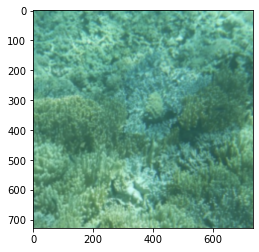

11.334102001307071 255.0
0.7286383721834488 255.0
0.0 255.0


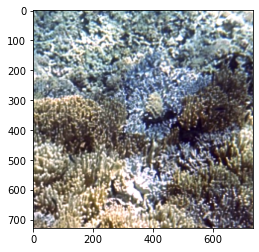

In [155]:
pic_name = '15.png'
im = np.array(cv2.cvtColor(cv2.imread(pic_name), cv2.COLOR_BGR2RGB).astype('double') / 255.0)
plt.imshow(im)
plt.show()
plt.imshow(RETINEX_BASED(im))
plt.show()

In [141]:
# input: original & dehaze image
# output: evaluation e value
def evaluation_e(original, dehaze):
    if np.max(original)<=1:
        original_ = original*255
    else:
        original_ = original*1
    if np.max(dehaze)<=1:
        dehaze_ = dehaze*255
    else:
        dehaze_ = dehaze*1
    edges_origin = cv2.Canny(np.uint8(original_), threshold1=10, threshold2=35)
    edges_dehaze = cv2.Canny(np.uint8(dehaze_), threshold1=10, threshold2=35)
    # plt.imshow(edges_origin,cmap='gray')
    # plt.show()
    # plt.imshow(edges_dehaze,cmap='gray')
    # plt.show()
    return (np.sum(edges_dehaze)-np.sum(edges_origin))/np.sum(edges_origin)

# input: original & dehaze should be in RGB sequence
#        threshold_uppor: the value large than this is regarded as saturated (black)
#        threshold_lower: the value smaller than this is regarded as saturated (white)
# output: evaluation sigma value
def evaluation_sigma(original, dehaze, threshold_upper=250, threshold_lower=10):
    H,W,garbage = np.shape(original)
    if np.max(original)<=1:
        original_ = np.uint8(original*255)
    else:
        original_ = np.uint8(original*1)
    if np.max(dehaze)<=1:
        dehaze_ = np.uint8(dehaze*255)
    else:
        dehaze_ = np.uint8(dehaze*1)
    original_gray = cv2.cvtColor(original_, cv2.COLOR_RGB2GRAY)
    dehaze_gray = cv2.cvtColor(dehaze_, cv2.COLOR_RGB2GRAY)
    sigma = np.sum((dehaze_gray>threshold_upper)*(1-(original_gray>threshold_upper)))
    sigma+= np.sum((dehaze_gray<threshold_lower)*(1-(original_gray<threshold_lower)))
    return 1.0*sigma/(H*W)

11.334102001307071 255.0
0.7286383721834488 255.0
0.0 255.0


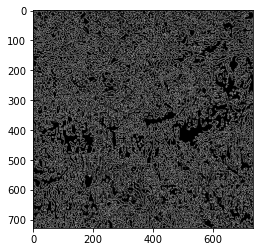

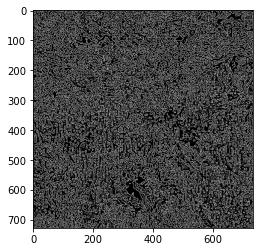

e: 0.12274583191561755
11.334102001307071 255.0
0.7286383721834488 255.0
0.0 255.0
sigma: 0.039088466029882925


In [156]:
print('e:',evaluation_e(im,RETINEX_BASED(im)))
print('sigma:',evaluation_sigma(im,RETINEX_BASED(im)))

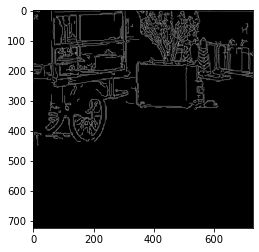

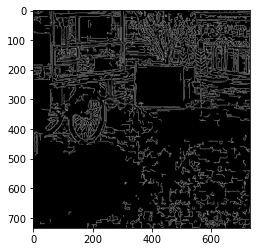

e: 1.1803217358772915


In [154]:
pic_name = 'e1.png'
im = np.array(cv2.cvtColor(cv2.imread(pic_name), cv2.COLOR_BGR2RGB).astype('double') / 255.0)
pic_name = 'e2.png'
im2 = np.array(cv2.cvtColor(cv2.imread(pic_name), cv2.COLOR_BGR2RGB).astype('double') / 255.0)
print('e:',evaluation_e(im,im2))